In [2]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [3]:
data = pd.read_csv('Data/autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [173]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [174]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$



Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавая свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками.

Класс MeanTargetEncoderNoise должен иметь следующую сигнатуру:



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):

    def __init__(self, categorical, numeric):
        pass
        ### Your code is here

    def fit(self, X, y):
        ### Your code is here

        return self

    def transform(self, df):
        pass
        ### Your code is here

        # return temp

Разделите колонки на вещественные и категориальные. Приведите все категориальные колонки к типу `object`.

Далее применим наш кодировщик к `X_train, X_test`, так же как например мы применяем `StandardScaler`, чтобы проверить работоспособность нашего класса. Установите зерно датчика случайный чисел `np.random.seed(1)`.

После того, как вы изменили обучающую и тестовую выборки, сохраните первые 10 строк полученного промежуточного датафрейма обучающей выборки (`X_train`) в файл в формате csv с сепаратором `;`. Не забудьте индекс. Отправьте полученный файл в форму ниже.

Список колонок которые должны быть в файле для сдачи:
```py
cols = [
    "km_driven",
    "name",
    "year",
    "fuel",
    "seller_type",
    "transmission",
    "owner"
]
```

### Ваше решение


Разделение колонок на категориальные и числовые.

In [175]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


Реализация класса MeanTargetEncoderNoise.

In [176]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np


class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):

    def __init__(self, categorical, numeric):
        self.categorical = categorical
        self.numeric = numeric

    def fit(self, X, y):
        X_ = pd.concat([X, y], axis=1)

        self.dict_of_means = {col: X_.groupby(col)[y.name].mean()
                              for col in self.categorical}

        return self

    def transform(self, df: pd.DataFrame):
        X_ = df.copy()

        for col in self.categorical:
            X_[col] = X_[col].map(self.dict_of_means[col])  # крутая тема

            X_[col] += 0.006 * np.random.normal(loc=0, scale=1, size=X_[col].shape[0])

            X_[col] = X_[col].fillna(0)

        return X_

Проверка работы трансформера.

In [177]:
cols = [
    "km_driven",
    "name",
    "year",
    "fuel",
    "seller_type",
    "transmission",
    "owner"
]

In [178]:
np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train[cols].head(10).to_csv('Data/result.csv', index=False, sep=';')

Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [194]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

max_depth:
3 - 0.82
5 - 1.44
8 - 1.99
12 - 1.42

min_samples_split
10 - 1.45
50 - 1.45
100 - 0.98
500 - 0.81

min_impurity_decrease
0 - 1.55
0.1 - 0.53
0.15 - 0.52
0.2 - 0.52

max_leaf_nodes
100 - 1.45
200 - 2.0
500 - 2.0


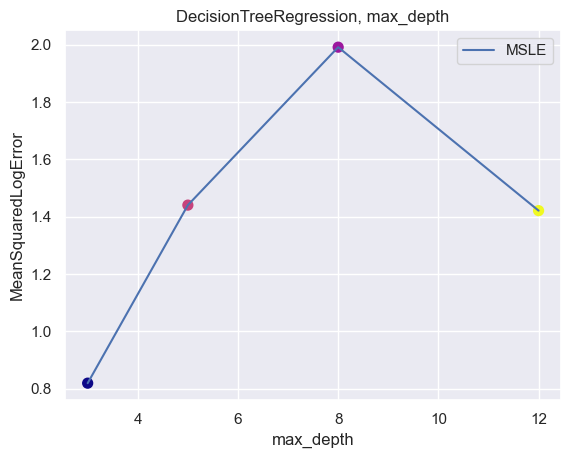

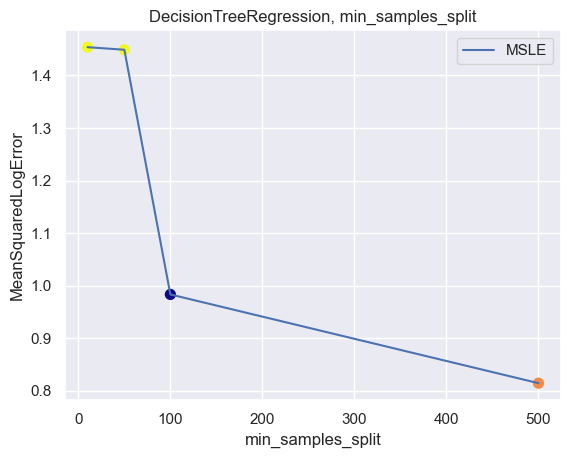

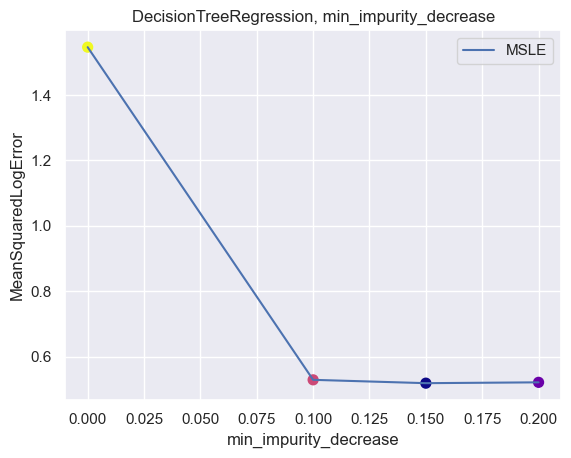

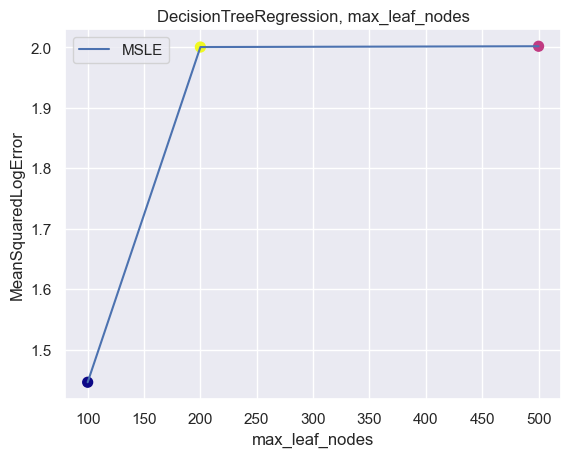

In [203]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1)

### Your code is here
fig, ax = plt.subplots()
msle_values = []
print(f'max_depth:')
for max_depth in max_depth_list:
    pipe = Pipeline(steps=[('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                           ('tree', DecisionTreeRegressor(max_depth=max_depth))])
    pipe.fit(X_train, y_train)
    y_pred = mean_squared_error(y_test, pipe.predict(X_test))
    msle_values.append(y_pred)
    print(f'{max_depth} - {y_pred.__round__(2)}')

ax.set_xlabel('max_depth')
ax.set_ylabel('MeanSquaredLogError')
ax.set_title("DecisionTreeRegression, max_depth")

sns.lineplot(x=max_depth_list, y=msle_values, label='MSLE')
plt.scatter(max_depth_list, msle_values, c=np.random.rand(len(max_depth_list)), cmap='plasma', s=50)

fig, ax = plt.subplots()
msle_values = []
print(f'\nmin_samples_split')
for min_samples_split in min_samples_split_list:
    pipe = Pipeline(steps=[('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                           ('tree', DecisionTreeRegressor(min_samples_split=min_samples_split))])
    pipe.fit(X_train, y_train)
    y_pred = mean_squared_error(y_test, pipe.predict(X_test))
    msle_values.append(y_pred)
    print(f'{min_samples_split} - {y_pred.__round__(2)}')

ax.set_xlabel('min_samples_split')
ax.set_ylabel('MeanSquaredLogError')
ax.set_title("DecisionTreeRegression, min_samples_split")

sns.lineplot(x=min_samples_split_list, y=msle_values, label='MSLE')
plt.scatter(min_samples_split_list, msle_values, c=np.random.rand(len(min_samples_split_list)), cmap='plasma', s=50)

fig, ax = plt.subplots()

print(f'\nmin_impurity_decrease')
msle_values = []
for min_impurity_decrease in min_impurity_decrease_list:
    pipe = Pipeline(steps=[('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                           ('tree', DecisionTreeRegressor(min_impurity_decrease=min_impurity_decrease))])
    pipe.fit(X_train, y_train)
    y_pred = mean_squared_error(y_test, pipe.predict(X_test))
    msle_values.append(y_pred)
    print(f'{min_impurity_decrease} - {y_pred.__round__(2)}')

ax.set_xlabel('min_impurity_decrease')
ax.set_ylabel('MeanSquaredLogError')
ax.set_title("DecisionTreeRegression, min_impurity_decrease")

sns.lineplot(x=min_impurity_decrease_list, y=msle_values, label='MSLE')
plt.scatter(min_impurity_decrease_list, msle_values, c=np.random.rand(len(min_impurity_decrease_list)), cmap='plasma',
            s=50)

fig, ax = plt.subplots()

print(f'\nmax_leaf_nodes')
msle_values = []
for max_leaf_nodes in max_leaf_nodes_list:
    pipe = Pipeline(steps=[('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                           ('tree', DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes))])
    pipe.fit(X_train, y_train)
    y_pred = mean_squared_error(y_test, pipe.predict(X_test))
    msle_values.append(y_pred)
    print(f'{max_leaf_nodes} - {y_pred.__round__(2)}')

ax.set_xlabel('max_leaf_nodes')
ax.set_ylabel('MeanSquaredLogError')
ax.set_title("DecisionTreeRegression, max_leaf_nodes")

sns.lineplot(x=max_leaf_nodes_list, y=msle_values, label='MSLE')
plt.scatter(max_leaf_nodes_list, msle_values, c=np.random.rand(len(max_leaf_nodes_list)), cmap='plasma', s=50)


Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [206]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

### Your code is here
gs_pipe = Pipeline(steps=[('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                          ('decision_tree', DecisionTreeRegressor())])
tree_gs = GridSearchCV(estimator=gs_pipe, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=10)
tree_gs.fit(X_train, y_train)
tree_gs.score(X_test, y_test)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/5; 1/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.062 total time=   0.0s
[CV 2/5; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 2/5; 1/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.804 total time=   0.0s
[CV 3/5; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 3/5; 1/192] END decision_tree__max_depth=3, decision_tree__max_l

C:\Users\merku\.virtualenvs\MachineLearning-x7kuzlXN\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


-0.5175843229295338